In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyreadr
import matplotlib.cm as cm
import matplotlib.colors as colors

In [114]:
def generate_colors_for_locations(locs, cmap_name='Set1'):
    """
    Given a list of location names, return a list of colors using
    the full range of the chosen colormap. Colors are assigned based
    on alphabetical ordering but returned in the given list order.
    """

    # Unique sorted list to map full colormap range
    unique_sorted = sorted(set(locs))

    # Colormap and normalizer
    cmap = plt.get_cmap(cmap_name)
    norm = colors.Normalize(vmin=0, vmax=len(unique_sorted) - 1)

    # Dictionary: location → assigned color
    color_map = {loc: cmap(norm(i)) for i, loc in enumerate(unique_sorted)}

    # Return a color for each input location, preserving original order
    return [color_map[loc] for loc in locs]

In [163]:
def time_plot(variable, locs, scale=2, start_year=2000, start_month=1, end_year=2030, end_month=12, capitals=False, saveto=None, covid=False, m='Set1'):
    label_dict = {l:l for l in locs}
    if capitals:
        # load province_to_capital.csv to a python dictionary
        province_to_capital = pd.read_csv('base_info/province_to_capital.csv')
        province_to_capital = dict(zip(province_to_capital['province'], province_to_capital['capital']))
        if scale==1:
            scale = 2
            label_dict = {province_to_capital[loc] : loc+' (' + province_to_capital[loc] + ')' for loc in locs if loc in province_to_capital}
            locs = [province_to_capital[loc] for loc in locs if loc in province_to_capital]
        elif scale==2:
            locs = [loc for loc in locs if loc in province_to_capital.values()]
            label_dict = {l:l for l in locs}

    start = pd.to_datetime(f"{start_year}-{start_month}-01")
    end   = pd.to_datetime(f"{end_year}-{end_month}-01")

    valid_admin = pd.read_csv(f'base_info/admin{scale}_unique.csv', header=None)[0].tolist()

    _ = pd.read_csv('base_info/var_to_file.csv')
    var_to_file_loaded = dict(zip(_['variable'], _['file_name']))
    file = var_to_file_loaded[variable]

    if file[0]=='[':
        file = file.strip("[]").replace("'", "")
        file = [x.strip() for x in file.split(',') if x.strip()]
    else:
        file = file

    if variable in ['rhumidity', 'rhumidity_pop_weighted',
                    'precipitation_mm', 'precipitation_mm_pop_weighted',
                    'temperature_celsius', 'temperature_celsius_pop_weighted']:

        file = file.replace('2', str(scale))
        d_var = pyreadr.read_r('dengue_indonesia_yifan/data/'+file)[None]
        d_var = d_var[d_var[f'admin{scale}'].isin(valid_admin)]

        # Convert month_year to datetime
        d_var['year'] = d_var['month_year'].astype(str).str.extract(r'\[(\d+)\.')[0].astype(int)
        d_var['month'] = d_var['month_year'].astype(str).str.extract(r'\.(\d+)\]')[0].astype(int)
        d_var['date'] = pd.to_datetime(d_var[['year','month']].assign(day=1))

        df = d_var.loc[(d_var['date'] >= start) & (d_var['date'] <= end),
                       [f'admin{scale}', variable, 'date']]
        df = df[df[f'admin{scale}'].isin(locs)]

    elif variable in ['cases', 'deaths']:
        d_var = pyreadr.read_r('dengue_indonesia_yifan/data/'+file)[None]
        d_var = d_var[d_var[f'admin{scale}'].isin(valid_admin)]

        d_var['date'] = pd.to_datetime(d_var[['year','month']].assign(day=1))

        # FILTER FIRST — DO NOT OVERWRITE LATER
        df = d_var.loc[(d_var['date'] >= start) & (d_var['date'] <= end),
                       [f'admin{scale}', variable, 'date']]
        df = df.groupby([f'admin{scale}', 'date'], as_index=False).sum()
        df = df[df[f'admin{scale}'].isin(locs)]

    # PLOTTING
    plt.figure(figsize=(10,6))
    colors = generate_colors_for_locations(label_dict.values(), cmap_name=m)
    for loc, color in zip(locs, colors):
        df_loc = df[df[f'admin{scale}'] == loc].sort_values('date')
        plt.plot(df_loc['date'], df_loc[variable], label=label_dict[loc], color=color, alpha=0.8)
    ###
    if covid:
        # Add COVID-period shading
        covid_start_1 = pd.to_datetime("2020-08-30")
        covid_end_1   = pd.to_datetime("2021-09-12")
        covid_start_2   = pd.to_datetime("2021-09-17")
        covid_end_2   = pd.to_datetime("2022-12-31")
        plt.axvspan(covid_start_1, covid_end_2,
                    alpha=0.15, color='grey')
        # plt.axvspan(covid_start_2, covid_end_2,
                    # alpha=0.1, color='grey', label='Transition period')
        ymax = plt.gca().get_ylim()[1]
        midpoint = covid_start_1 + (covid_end_2 - covid_start_1) / 2
        plt.text(midpoint, ymax * 0.98, "COVID",
             ha='center', va='top', fontsize=10,
             color='black')
    ###
    #title
    if capitals:
        plt.title(f"Time Plot of {variable.capitalize()} from {min(df['date']).strftime('%Y-%m')} to {max(df['date']).strftime('%Y-%m')} at Admin Level {scale} (Capitals)")
    else:
        plt.title(f"Time Plot of {variable.capitalize()} from {min(df['date']).strftime('%Y-%m')} to {max(df['date']).strftime('%Y-%m')} at Admin Level {scale}   ")
    
    # Sort legend labels alphabetically
    handles, labels = plt.gca().get_legend_handles_labels()
    sorted_pairs = sorted(zip(labels, handles), key=lambda x: x[0])
    labels_sorted, handles_sorted = zip(*sorted_pairs)
    plt.legend(handles_sorted, labels_sorted, loc='upper left', bbox_to_anchor=(1, 1.05), fontsize='small')

    if saveto:
        plt.savefig(saveto, bbox_inches='tight', dpi=300)
    plt.show()


In [164]:
all_provinces = pd.read_csv('base_info/admin1_unique.csv', header=None)[0].tolist()
all_districts = pd.read_csv('base_info/admin2_unique.csv', header=None)[0].tolist()

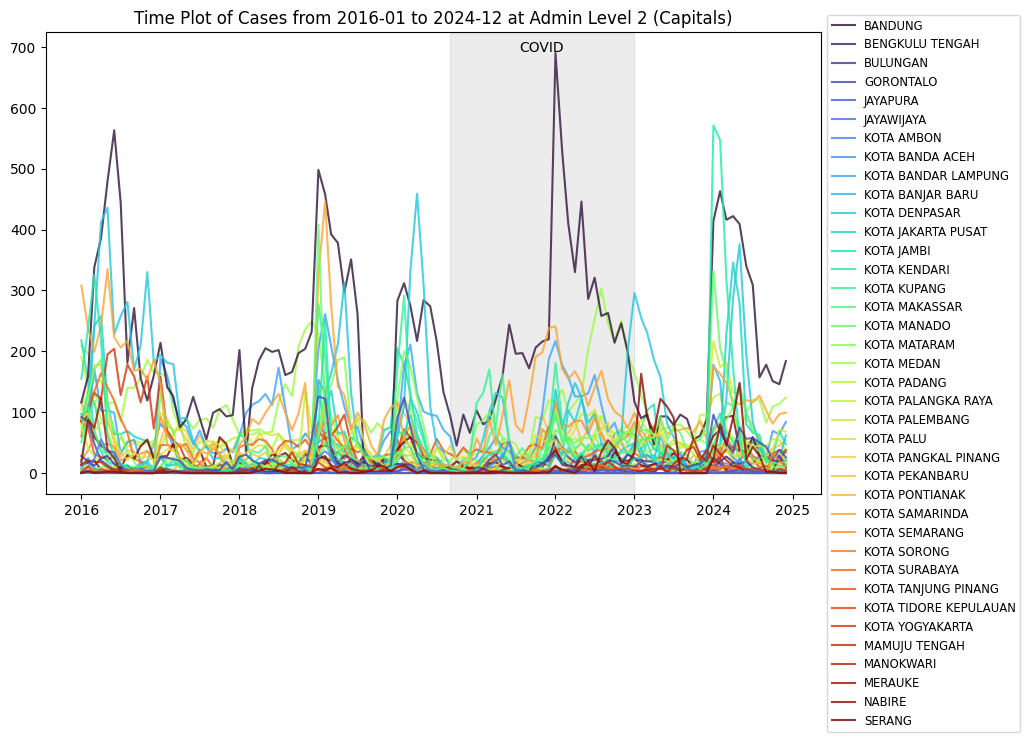

In [181]:
np.random.seed(4)
# time_plot('cases', locs=np.random.choice(all_districts[:], size=514, replace=False), scale=2, capitals=False, covid=True, m='turbo')#, saveto='figures/time_cases_districts_sample.png')

time_plot('cases', locs=all_districts[:], scale=2, capitals=True, covid=True, m='turbo')

https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Indonesia
Start of Covid: March 2020
End of Restrictions: December 2022

from the province level it seems like dengue cases reporting was disrupted roughly from march 2020 to roughly August 2021, might keep second period until end of 2022 as this marked the end of restrictions.

DATES are hard to decide
https://www.worldometers.info/coronavirus/country/indonesia/

There may be complicated dynamics at play during covid: misreporting, less reporting, less cases, movement restrictions, surges after periods of low cases due to lost immunity. Probably best to fit the model on 2016 - start covid data and then try to incorporate it with an indicator variable or two. Maybe include a immunity factor.

for nonlinear weather - incidence relationships need to use nonlinear transformation of data = GAM Generalised Additive Model, number of splines to fit the curve/data